<a href="https://colab.research.google.com/github/hshintree/FinRL/blob/master/Lag_Llama_Fine_Tuning_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lag-Llama Fine Tuning

## Prepare the repository

We first clone and install the required packages from the [GitHub repository](https://github.com/time-series-foundation-models/lag-llama/) that has the Lag-Llama architecture.

In [ ]:
!git clone -b update-gluonts https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 481, done.
remote: Counting objects: 100% (319/319), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 481 (delta 206), reused 255 (delta 166), pack-reused 162 (from 1)
Receiving objects: 100% (481/481), 270.81 KiB | 1.38 MiB/s, done.
Resolving deltas: 100% (247/247), done.


In [ ]:
cd /content/lag-llama

/content/lag-llama


In [ ]:
!pip uninstall jax jaxlib tensorboard -y

Found existing installation: tensorboard 2.18.0
Uninstalling tensorboard-2.18.0:
  Successfully uninstalled tensorboard-2.18.0


In [ ]:
!pip install -U -r requirements.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

We then download our pretrained model weights from [HuggingFace](https://huggingface.co/time-series-foundation-models/Lag-Llama) 🤗

In [ ]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

lag-llama.ckpt: 100% 29.5M/29.5M [00:00<00:00, 36.4MB/s]
Download complete. Moving file to /content/lag-llama/lag-llama.ckpt
/content/lag-llama/lag-llama.ckpt


## Imports

We import the required packages and the lag llama estimator object which we can use to make predictions.

In [ ]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

<ipython-input-2-3749d135369e>:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
import sys
from types import ModuleType

# Create dummy module hierarchy
def create_dummy_module(module_path):
    """
    Create a dummy module hierarchy for the given path.
    Returns the leaf module.
    """
    parts = module_path.split('.')
    current = ''
    parent = None

    for part in parts:
        current = current + '.' + part if current else part
        if current not in sys.modules:
            module = ModuleType(current)
            sys.modules[current] = module
            if parent:
                setattr(sys.modules[parent], part, module)
        parent = current

    return sys.modules[module_path]

# Create the dummy gluonts module hierarchy
gluonts_module = create_dummy_module('gluonts.torch.modules.loss')

# Create dummy classes for the specific loss functions
class DistributionLoss:
    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        return 0.0

    def __getattr__(self, name):
        return lambda *args, **kwargs: None

class NegativeLogLikelihood:
    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        return 0.0

    def __getattr__(self, name):
        return lambda *args, **kwargs: None

# Add the specific classes to the module
gluonts_module.DistributionLoss = DistributionLoss
gluonts_module.NegativeLogLikelihood = NegativeLogLikelihood

We create a function for Lag-Llama inference that we can reuse. This function returns the predictions for the given prediction horizon. The forecast will be of shape (num_samples, prediction_length), where `num_samples` is the number of samples sampled from the predicted probability distribution for each timestep.

In [ ]:
def get_lag_llama_predictions(dataset, prediction_length, context_length=32, num_samples=20, device="cuda", batch_size=64, nonnegative_pred_samples=True):
    ckpt = torch.load("lag-llama.ckpt", map_location=device, weights_only=False)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        nonnegative_pred_samples=nonnegative_pred_samples,

        # linear positional encoding scaling
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },

        batch_size=batch_size,
        num_parallel_samples=num_samples,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

    return forecasts, tss

## Zero Shot on `M4-Weekly`

In [ ]:
dataset = get_dataset("m4_weekly")

In [ ]:
prediction_length = dataset.metadata.prediction_length
context_length = prediction_length*3
num_samples = 20
device = "cuda"

In [ ]:
forecasts, tss = get_lag_llama_predictions(
    dataset.test,
    prediction_length=prediction_length,
    num_samples=num_samples,
    context_length=context_length,
    device=device
)

<ipython-input-4-3f8a67d29b95>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("lag-llama.ckpt", map_location=device)


Forecasting batches:   0%|          | 0/359 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/359 [00:00<?, ?it/s]

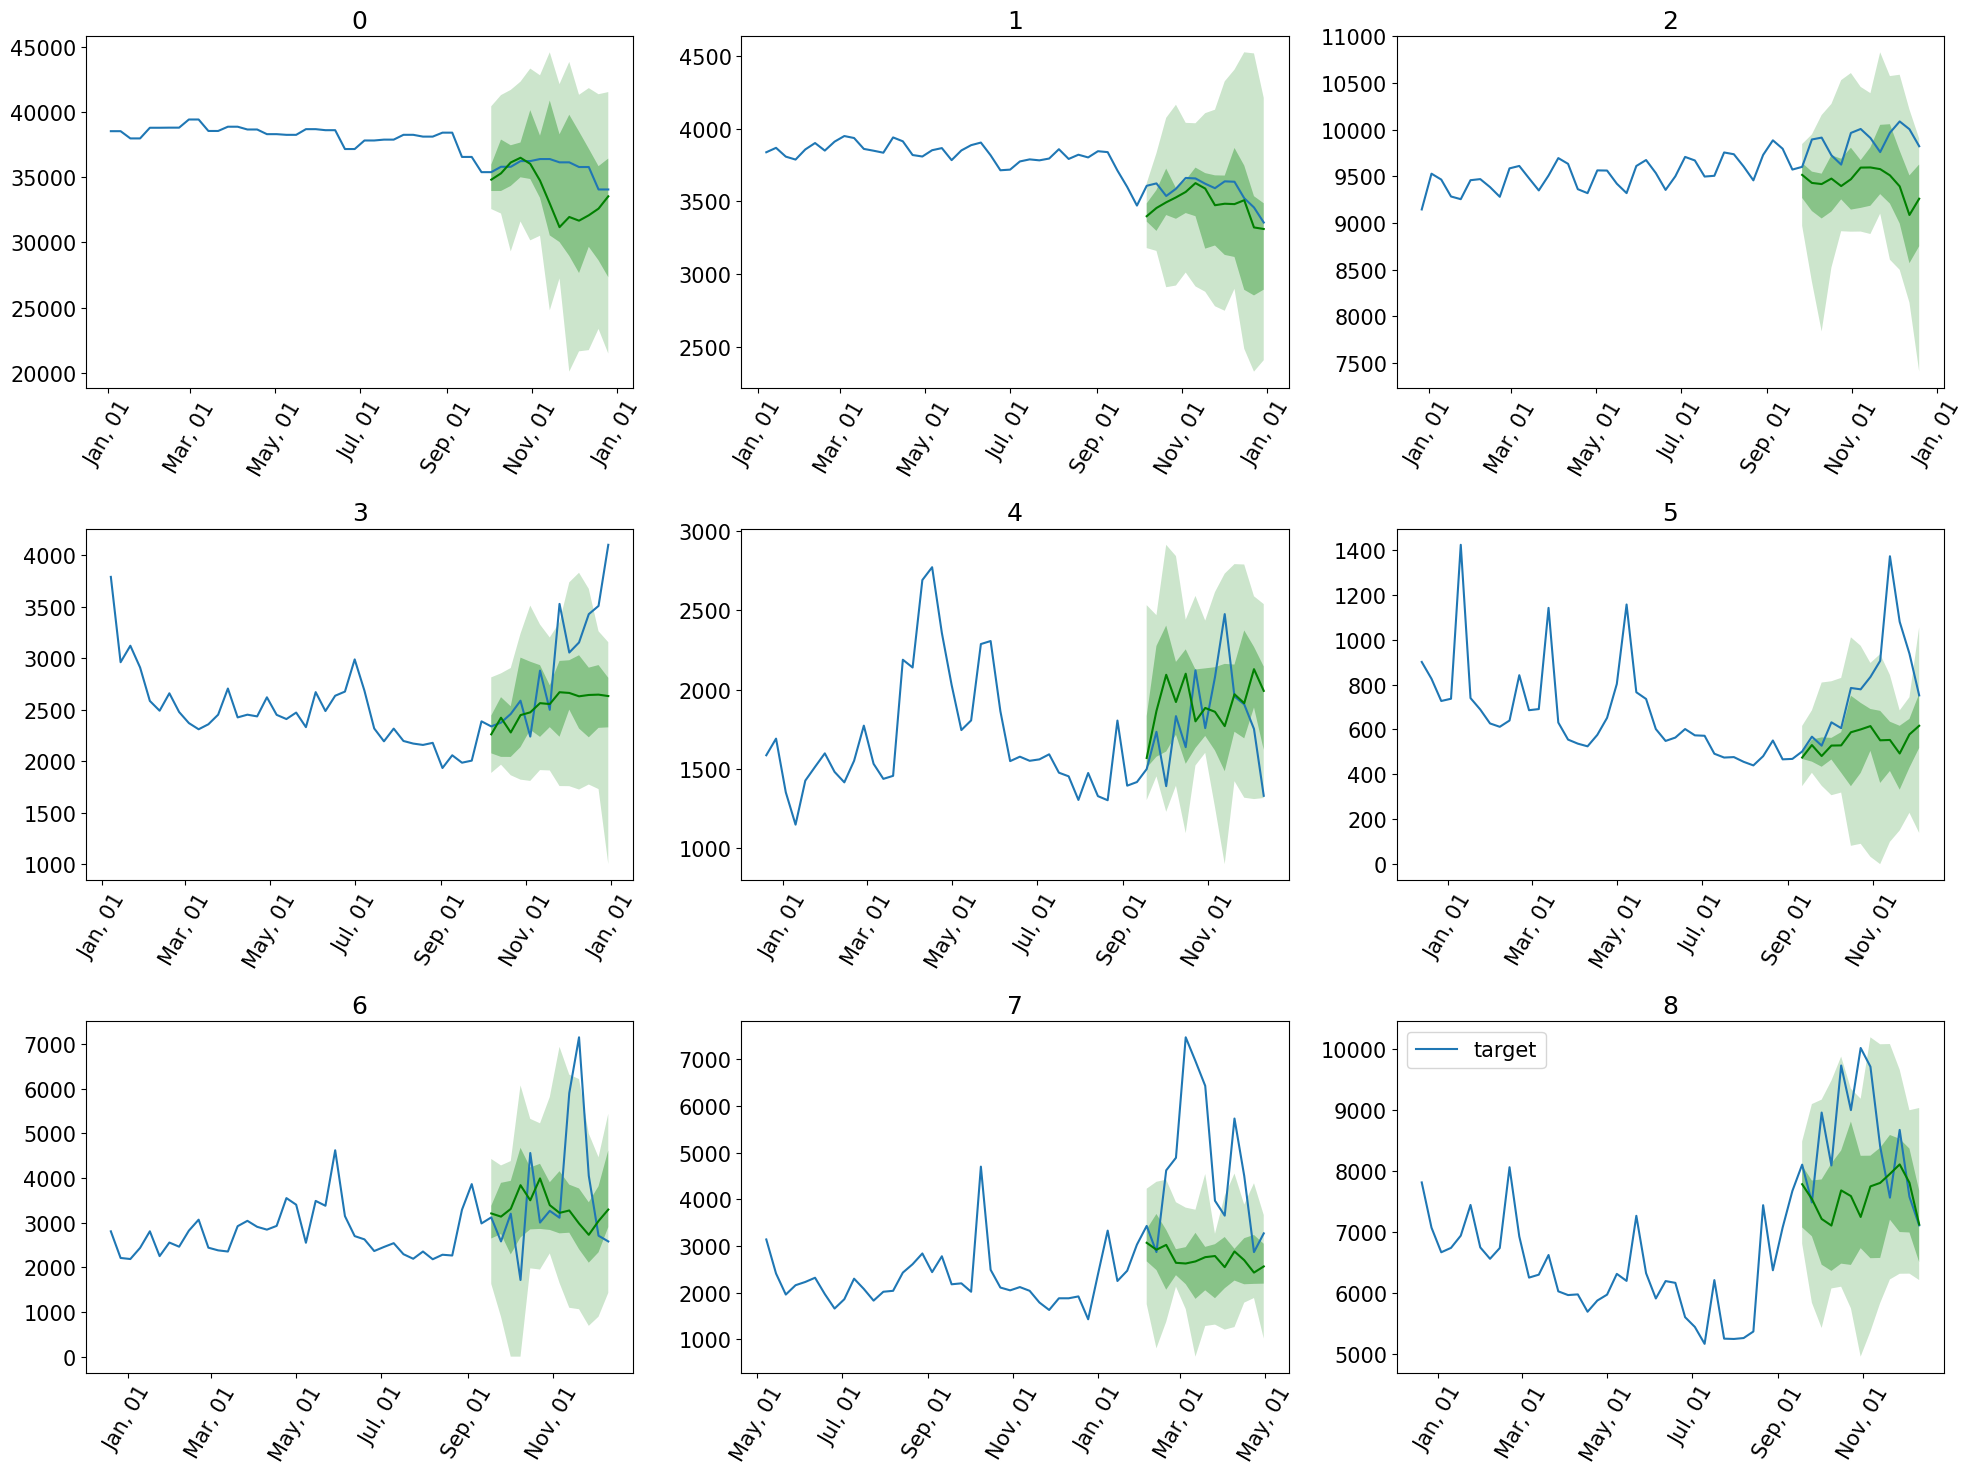

In [ ]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

## Fine-tuning

Let us fine-tune the Lag-Llama base model with a few data-specific changes. Feel Free to change the hyperparameters below:

In [ ]:
ckpt = torch.load("lag-llama.ckpt", map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=5e-4,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        # },

        batch_size=64,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 50,}, # <- lightning trainer arguments
    )

<ipython-input-8-fbb21606f06a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("lag-llama.ckpt", map_location=device)


In [ ]:
predictor = estimator.train(dataset.train, cache_data=True, shuffle_buffer_length=1000)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: 

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 8.12382 (best 8.12382), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 8.12382 (best 8.12382), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached 6.93075 (best 6.93075), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 6.93075 (best 6.93075), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached 6.87362 (best 6.87362), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pytor

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset.test,
        predictor=predictor,
        num_samples=num_samples
    )

In [ ]:
forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))

Forecasting batches:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

Ground truth:   0%|          | 0/3 [00:00<?, ?it/s]

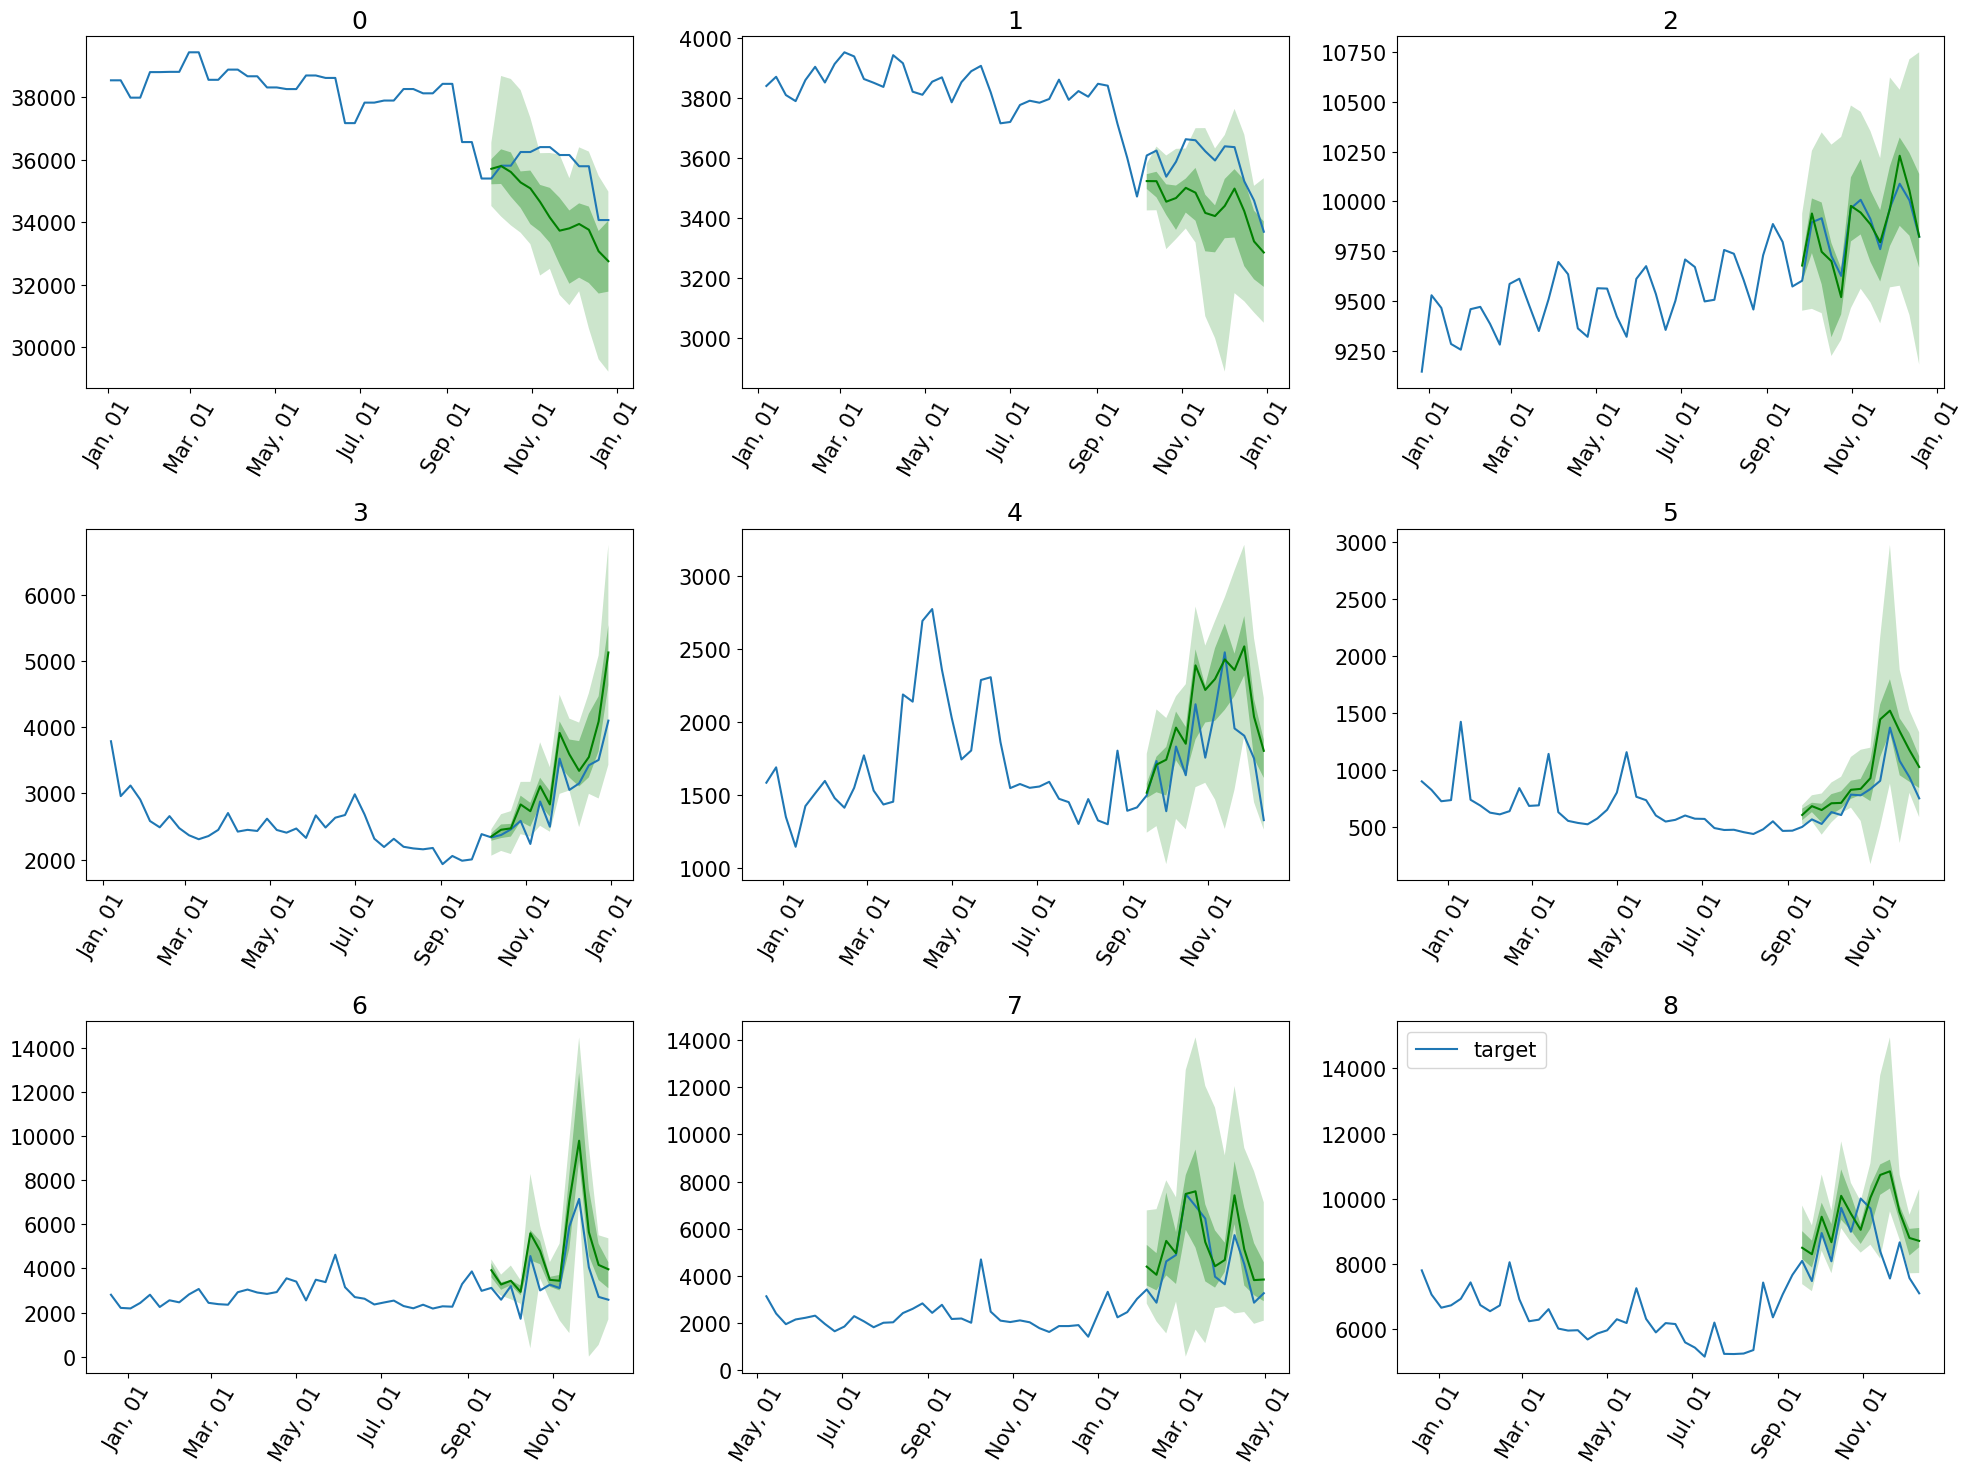

In [ ]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [ ]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))


Running evaluation: 359it [00:00, 1404.75it/s]


In [ ]:
agg_metrics

{'MSE': 895502.105291255,
 'abs_error': 2217801.732788086,
 'abs_target_sum': 25616889.502441406,
 'abs_target_mean': 5488.941397566189,
 'seasonal_error': 216.54813922503874,
 'MASE': 5.945667516464138,
 'MAPE': 0.11500357778214887,
 'sMAPE': 0.1268453279596747,
 'MSIS': 61.283062442026306,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 945429.3985244752,
 'Coverage[0.1]': 0.023998285836725954,
 'QuantileLoss[0.2]': 1511272.4744506837,
 'Coverage[0.2]': 0.04371116348832226,
 'QuantileLoss[0.3]': 1871415.8454315187,
 'Coverage[0.3]': 0.07156631669166487,
 'QuantileLoss[0.4]': 2117813.458444214,
 'Coverage[0.4]': 0.11742018427255196,
 'QuantileLoss[0.5]': 2217801.726020813,
 'Coverage[0.5]': 0.17870152131990574,
 'QuantileLoss[0.6]': 2371192.2054992677,
 'Coverage[0.6]': 0.21362759802871223,
 'QuantileLoss[0.7]': 2258808.70982666,
 'Coverage[0.7]': 0.30040711377758733,
 'QuantileLoss[0.8]': 1979941.852053833,
 'Coverage[0.8]': 0.4383972573387616,
 'QuantileLoss[0.9]': 1503662.9